In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 80

import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [2]:
players = pd.read_pickle('../TASK1/dataset/final_players.pkl')

In [3]:
players = players[players.stats_match_count >= 6]

In [4]:
rank_cols = list(filter(lambda s : 'rank_sem' in s, players.columns))

players['top_player'] = (players['l1_sf_match_count'] + players['l2_sf_match_count'] > 0)
players['under_50'] = ((players[rank_cols] <= 50).sum(axis=1) != 0)
players.loc[(players['under_50'] == True) & (players['top_player'] == False), 'top_player'] = 1

In [5]:
players.top_player.value_counts()

False    1607
True      347
Name: top_player, dtype: Int64

In [6]:
INPUT_FEATURES = ['sex', 'ace_mean', 'ace_ratio', 'df_mean', 'df_ratio', 'bp_saved_ratio', 'bp_w_ratio', 'svpt_w_ratio', 'svpt_1st_fail_ratio', 'w_ratio', 'hard_w_ratio', 'clay_w_ratio']

In [7]:
dataset = players[INPUT_FEATURES + ['top_player']].dropna()
X = dataset[INPUT_FEATURES].copy()
y = dataset['top_player'].copy()

In [8]:
X['sex'] = X['sex'].astype('category')
X['sex'], unique_names_sex = pd.factorize(X['sex'])
X = (X.astype('float')).values

y = (y.replace({True: 'Top', False: 'Low'})).astype('category')
y, unique_names_label = pd.factorize(y)
y = y.astype('float')

In [9]:
n_top = (y == unique_names_label.codes[unique_names_label.categories.get_loc('Top')]).sum()
n_low = (y == unique_names_label.codes[unique_names_label.categories.get_loc('Low')]).sum()
n_top / (n_top + n_low)

0.20654761904761904

In [10]:
print(f'# Top players: {n_top}')
print(f'# Low players: {n_low}')
print(f'Low : Top = 1 : {n_top / n_low}')

# Top players: 347
# Low players: 1333
Low : Top = 1 : 0.2603150787696924


---

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=13)
scaler_std = StandardScaler()
X_train = scaler_std.fit_transform(X_train)
X_test = scaler_std.fit_transform(X_test)

In [12]:
from sklearn.model_selection import StratifiedKFold

stratified_kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=13
)

---
# 2 hidden layers

In [13]:
import tensorflow as tf
from tensorflow import keras

def build_model_2hl(units_hl1, units_hl2, activation_hl1, activation_hl2, l2_reg_term):
   
    model = keras.Sequential()
    
    model.add(keras.layers.Input(shape=(len(INPUT_FEATURES),)))
    
    model.add(keras.layers.Dense(
        units=units_hl1,
        activation=activation_hl1,
        kernel_regularizer=keras.regularizers.l2(l2_reg_term))
    )
    model.add(keras.layers.Dense(
        units=units_hl2,
        activation=activation_hl2,
        kernel_regularizer=keras.regularizers.l2(l2_reg_term))
    )
    
    model.add(keras.layers.Dense(units=1, activation="sigmoid"))
    
    return model

2022-01-04 16:55:35.190449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-04 16:55:35.191753: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
from scikeras.wrappers import KerasClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

wrapped_model = KerasClassifier(
    build_model_2hl,
    optimizer=keras.optimizers.Adam,
    loss=keras.losses.BinaryCrossentropy,
    epochs=300
)

sex_feature_index = np.where(np.array(INPUT_FEATURES) == 'sex')[0][0]
oversampling_smote = SMOTENC(categorical_features=[sex_feature_index])

pipeline_2hl = Pipeline(steps=[('smotenc', oversampling_smote), ('classif', wrapped_model)])

In [15]:
from scipy.stats import loguniform, uniform, randint

grid_params_2hl = {
    'smotenc__sampling_strategy':            uniform(0.27, 0.13), # uniform distr on [0.27, 0.40]
    
    'classif__model__units_hl1':             randint(32, 256),
    'classif__model__units_hl2':             randint(32, 256),
    'classif__model__activation_hl1':        ['relu', 'tanh', 'sigmoid'],
    'classif__model__activation_hl2':        ['relu', 'tanh', 'sigmoid'],
    'classif__model__l2_reg_term':           loguniform(0.00001, 0.01),
    
    'classif__optimizer__learning_rate':     loguniform(0.0001, 0.1),
    
    'classif__fit__batch_size':              [16, 32, 64]
}

grid_params_2hl

{'smotenc__sampling_strategy': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f33f0b993d0>,
 'classif__model__units_hl1': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f3432d4bc10>,
 'classif__model__units_hl2': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f33f0ba3220>,
 'classif__model__activation_hl1': ['relu', 'tanh', 'sigmoid'],
 'classif__model__activation_hl2': ['relu', 'tanh', 'sigmoid'],
 'classif__model__l2_reg_term': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f3432d4b370>,
 'classif__optimizer__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f33f0ba3130>,
 'classif__fit__batch_size': [16, 32, 64]}

In [16]:
from sklearn.model_selection import RandomizedSearchCV

random_states = range(13, 63)

rcv_results = pd.DataFrame()

for seed in random_states:
    rcv = RandomizedSearchCV(
        estimator=pipeline_2hl,
        param_distributions=grid_params_2hl,
        scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
        refit=False,
        n_iter=2,
        cv=stratified_kf,
        random_state=seed,
        n_jobs=-1
    )
    rcv.fit(X_train, y_train)
    rcv_results = pd.concat([rcv_results, pd.DataFrame(rcv.cv_results_)])
    keras.backend.clear_session()
    del rcv


2022-01-03 20:30:49.158834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-03 20:30:49.159109: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-03 20:30:49.274934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-03 20:30:49.275452: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-03 20:30:49.439649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/300


2022-01-03 20:30:53.460202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-03 20:30:53.460963: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-03 20:30:53.461436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-01-03 20:30:53.462193: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-03 20:30:53.673501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic l

Epoch 1/300


2022-01-03 20:30:53.988398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-03 20:30:53.988445: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-03 20:30:53.988479: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-01-03 20:30:53.988830: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/300
Epoch 1/300
17/17 [==============================] - 2s 5ms/step - loss: 1.1048
Epoch 2/300
17/17 [==============================] - 1s 6ms/step - loss: 2.0942
Epoch 2/300
17/17 [==============================] - 0s 6ms/step - loss: 0.5905
Epoch 3/300
17/17 [==============================] - 0s 5ms/step - loss: 0.5138
Epoch 4/300
17/17 [==============================] - 0s 11ms/step - loss: 0.9440
Epoch 3/300
17/17 [==============================] - 0s 6ms/step - loss: 0.4935
Epoch 5/300
17/17 [==============================]Epoch 4/300
 - 0s 6ms/step - loss: 0.5246
17/17 [==============================] - 1s 6ms/step - loss: 1.4661
Epoch 2/300
17/17 [==============================] - 0s 7ms/step - loss: 0.4962
Epoch 7/300
17/17 [==============================] - 0s 6ms/step - loss: 0.6393
Epoch 3/300
17/17 [==============================] - 0s 8ms/step - loss: 0.5374
Epoch 5/300
17/17 [==============================] - 0s 5ms/step - loss: 0.4873
Epoch 8/300
Epoch 4/300
17/

In [21]:
rcv_results.reset_index()[['mean_test_AUC', 'mean_test_Accuracy']].sort_values(by='mean_test_Accuracy', ascending=False).head(10)

,mean_test_AUC,mean_test_Accuracy
14,0.937538,0.885714
10,0.938231,0.884921
66,0.939038,0.883333
16,0.930981,0.883333
4,0.932923,0.882540
89,0.915365,0.880952
83,0.927250,0.880159
32,0.917529,0.879365
67,0.933692,0.879365
20,0.929740,0.877778


In [27]:
tmp['mean_tot'].sort_values(ascending=False)

14    1.823253
10    1.823151
66    1.822372
4     1.815463
16    1.814314
        ...   
80    1.687628
55    1.676161
37    1.674775
46    1.597569
33    1.365173
Name: mean_tot, Length: 100, dtype: float64

In [51]:
rcv_results.reset_index().loc[14]

index                                                                                      0
mean_fit_time                                                                      31.550577
std_fit_time                                                                        9.294344
mean_score_time                                                                     0.303993
std_score_time                                                                       0.06074
param_classif__fit__batch_size                                                            64
param_classif__model__activation_hl1                                                    relu
param_classif__model__activation_hl2                                                 sigmoid
param_classif__model__l2_reg_term                                                   0.002802
param_classif__model__units_hl1                                                          107
param_classif__model__units_hl2                                       

In [52]:
rcv_results.reset_index().loc[14].params

{'classif__fit__batch_size': 64,
 'classif__model__activation_hl1': 'relu',
 'classif__model__activation_hl2': 'sigmoid',
 'classif__model__l2_reg_term': 0.0028022858375219605,
 'classif__model__units_hl1': 107,
 'classif__model__units_hl2': 54,
 'classif__optimizer__learning_rate': 0.01189248864091381,
 'smotenc__sampling_strategy': 0.3192285224607031}

In [22]:
best_params = rcv_results.reset_index().loc[14].params

final_model = Pipeline([
    ('smotenc', SMOTENC(categorical_features=[sex_feature_index], sampling_strategy=best_params['smotenc__sampling_strategy'])),
    ('classif', KerasClassifier(
            build_model_2hl,
            optimizer=keras.optimizers.Adam(learning_rate=best_params['classif__optimizer__learning_rate']),
            loss=keras.losses.BinaryCrossentropy,
            epochs=300,
            model__activation_hl1=best_params['classif__model__activation_hl1'],
            model__activation_hl2=best_params['classif__model__activation_hl2'],
            model__l2_reg_term=best_params['classif__model__l2_reg_term'],
            model__units_hl1=best_params['classif__model__units_hl1'],
            model__units_hl2=best_params['classif__model__units_hl2']
        )
    )
])

final_model.fit(X_train, y_train)


2022-01-04 17:44:33.623049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-04 17:44:33.623258: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-04 17:44:33.623294: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-01-04 17:44:33.623788: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/300
42/42 [==============================] - 1s 2ms/step - loss: 0.6058
Epoch 2/300
42/42 [==============================] - 0s 3ms/step - loss: 0.4454
Epoch 3/300
42/42 [==============================] - 0s 4ms/step - loss: 0.4228
Epoch 4/300
42/42 [==============================] - 0s 4ms/step - loss: 0.4068
Epoch 5/300
42/42 [==============================] - 0s 4ms/step - loss: 0.4094
Epoch 6/300
42/42 [==============================] - 0s 2ms/step - loss: 0.3970
Epoch 7/300
42/42 [==============================] - 0s 2ms/step - loss: 0.3901
Epoch 8/300
42/42 [==============================] - 0s 2ms/step - loss: 0.3909
Epoch 9/300
42/42 [==============================] - 0s 3ms/step - loss: 0.3813
Epoch 10/300
42/42 [==============================] - 0s 3ms/step - loss: 0.3977
Epoch 11/300
42/42 [==============================] - 0s 3ms/step - loss: 0.3821
Epoch 12/300
42/42 [==============================] - 0s 4ms/step - loss: 0.3725
Epoch 13/300
42/42 [=================

Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0],
                         sampling_strategy=0.3192285224607031)),
                ('classif',
                 KerasClassifier(epochs=300, loss=<class 'keras.losses.BinaryCrossentropy'>, model=<function build_model_2hl at 0x7f3432d40a60>, model__activation_hl1='relu', model__activation_hl2='sigmoid', model__l2_reg_term=0.0028022858375219605, model__units_hl1=107, model__units_hl2=54, optimizer=<keras.optimizer_v2.adam.Adam object at 0x7f347c2d38e0>))])

14/14 [==============================] - 0s 2ms/step


No handles with labels found to put in legend.


              precision    recall  f1-score   support

         Top       0.72      0.75      0.73        87
         Low       0.93      0.92      0.93       333

    accuracy                           0.89       420
   macro avg       0.83      0.84      0.83       420
weighted avg       0.89      0.89      0.89       420

14/14 [==============================] - 0s 2ms/step


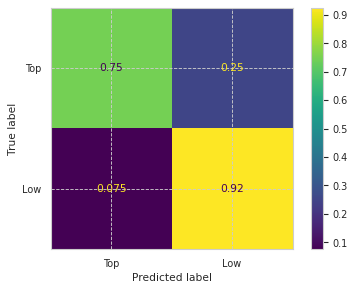

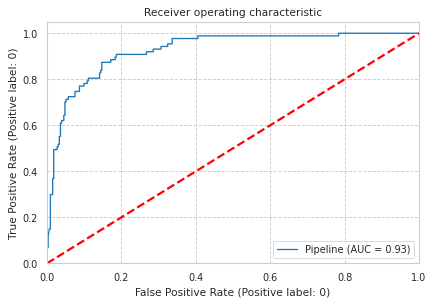

In [23]:
from sklearn.metrics import classification_report, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

predict_test = final_model.predict(X_test)
print(classification_report(y_test, predict_test, target_names=unique_names_label))
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_test, normalize='true'), display_labels=unique_names_label).plot()

f, ax = plt.subplots()
lw = 2
plt.plot([0, 1], [0, 1], color="r", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")

RocCurveDisplay.from_estimator(final_model, X_test, y_test, pos_label=0, ax=ax)